# A.C.E.L.S. Position Sensing NN Program

### Define Path to Model Files

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

### Import Dependencies

In [2]:
# Import libraries
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense

2024-02-22 21:09:25.982572: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 21:09:26.327577: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-22 21:09:26.328519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 21:09:27.531206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Import Dataset

In [3]:
# Assign dataset to data variable
data = pd.read_csv('position_data_float_xyz_extended.csv')

### Pre-process data

In [4]:
# Check dataset
data.head()
num_rows = data.shape[0]
print(num_rows)

13835


In [5]:
# Check datatype
data = data.sample(frac=1).reset_index(drop=True)
data.dtypes

# Convert dataframe to float 32
data32 = data.astype(np.float32)
data32.dtypes

s1    float32
s2    float32
s3    float32
s4    float32
s5    float32
s6    float32
s7    float32
s8    float32
x     float32
y     float32
z     float32
dtype: object

In [6]:
# Obtain data statistics
train_stats = data32.describe()
train_stats = train_stats.transpose()

print(train_stats)

# Separate Data into Feature and Target Variables
# The `_og` suffix refers to the original data without normalization
# It is assign to a variable to be later used for testing purposes
feature_data_og = data32[['s1','s2','s3','s4','s5','s6','s7','s8']]
target_data_og = data32[['x', 'y', 'z']]

# Check data shape and type
print(feature_data_og.shape[0])
print(type(feature_data_og.shape[0]))

# Split the data into  training and test sections
TRAIN_SPLIT = int(0.6 * feature_data_og.shape[0])
TEST_SPLIT = int(0.2 * feature_data_og.shape[0] + TRAIN_SPLIT)

feature_train_og, feature_test_og, feature_validate_og = np.split(feature_data_og, [TRAIN_SPLIT, TEST_SPLIT])
target_train_og, target_test_og, target_validate_og = np.split(target_data_og, [TRAIN_SPLIT, TEST_SPLIT])


      count        mean        std    min    25%    50%    75%    max
s1  13835.0  431.568329  75.837502  170.0  383.0  451.0  487.0  547.0
s2  13835.0  352.713837  72.866417  175.0  298.0  360.0  419.0  478.0
s3  13835.0  402.710724  77.235107  164.0  348.0  419.0  460.0  528.0
s4  13835.0  350.783173  79.198158  155.0  290.0  357.0  415.0  493.0
s5  13835.0  331.181427  76.769653  154.0  264.0  342.0  399.0  477.0
s6  13835.0  379.517822  80.937592  154.0  332.0  391.0  443.0  525.0
s7  13835.0  314.792633  74.028419  150.0  254.0  321.0  375.0  457.0
s8  13835.0  378.571075  88.135933  135.0  331.0  393.0  449.0  529.0
x   13835.0   -0.167329   8.387558  -20.0  -10.0    0.0   10.0   20.0
y   13835.0   -0.149982   8.411338  -20.0  -10.0    0.0   10.0   20.0
z   13835.0    2.568124   4.372630    0.0    0.0    0.0    5.0   15.0
13835
<class 'int'>


/home/zalnemeth/.cache/pypoetry/virtualenvs/acels-fmqPoMaW-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
# Normalize data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_data = norm(data32)

normed_data.head()

,s1,s2,s3,s4,s5,s6,s7,s8,x,y,z
0,-2.460106,-1.574303,0.172063,-1.865993,0.635910,-0.451185,0.610676,1.162170,-1.172292,1.206702,-0.587318
1,0.717741,0.566601,-0.384679,1.240140,0.375390,1.266188,1.556259,0.492749,1.212192,1.206702,1.699635
2,0.269414,0.909694,1.324388,-0.792735,1.065767,-2.168558,-1.375048,0.549480,-1.172292,-1.171041,-0.587318
3,-0.271216,0.552877,0.806489,0.141630,1.339313,0.117154,1.056451,1.139478,-1.172292,0.017831,1.699635
4,-2.460106,-1.546856,0.288590,-1.853366,0.714066,-0.525316,0.543134,1.162170,-1.172292,1.206702,-0.587318


In [8]:
# Separate Data into Feature and Target Variables
feature_data = normed_data[['s1','s2','s3','s4','s5','s6','s7','s8']]
target_data = normed_data[['x', 'y', 'z']]

In [9]:
feature_data.head()

,s1,s2,s3,s4,s5,s6,s7,s8
0,-2.460106,-1.574303,0.172063,-1.865993,0.635910,-0.451185,0.610676,1.162170
1,0.717741,0.566601,-0.384679,1.240140,0.375390,1.266188,1.556259,0.492749
2,0.269414,0.909694,1.324388,-0.792735,1.065767,-2.168558,-1.375048,0.549480
3,-0.271216,0.552877,0.806489,0.141630,1.339313,0.117154,1.056451,1.139478
4,-2.460106,-1.546856,0.288590,-1.853366,0.714066,-0.525316,0.543134,1.162170


### Splitting the Data

In [10]:
feature = feature_data
target = target_data

In [11]:
# Assign 60% of data for training
# Assign 20% of data for testing
# Assign 20% pf data to validation
TRAIN_SPLIT = int(0.6 * feature.shape[0])
TEST_SPLIT = int(0.2 * feature.shape[0] + TRAIN_SPLIT)

feature_train, feature_test, feature_validate = np.split(feature, [TRAIN_SPLIT, TEST_SPLIT])
target_train, target_test, target_validate = np.split(target, [TRAIN_SPLIT, TEST_SPLIT])

# Check split data
feature_train.head()
target_train.head()

/home/zalnemeth/.cache/pypoetry/virtualenvs/acels-fmqPoMaW-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,x,y,z
0,-1.172292,1.206702,-0.587318
1,1.212192,1.206702,1.699635
2,-1.172292,-1.171041,-0.587318
3,-1.172292,0.017831,1.699635
4,-1.172292,1.206702,-0.587318


### Building and Training the Model

In [12]:
# Create model with 8 input, 3 output and 5 hidden layers
model = tf.keras.Sequential()
model.add(Dense(60, activation='tanh', input_shape=(8,)))
model.add(Dense(80, activation='tanh'))
model.add(Dense(80, activation='tanh'))
model.add(Dense(60, activation='tanh'))
model.add(Dense(30, activation='tanh'))
model.add(Dense(3))
model.compile(optimizer='nadam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                540       
                                                                 
 dense_1 (Dense)             (None, 80)                4880      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 dense_3 (Dense)             (None, 60)                4860      
                                                                 
 dense_4 (Dense)             (None, 30)                1830      
                                                                 
 dense_5 (Dense)             (None, 3)                 93        
                                                                 
Total params: 18683 (72.98 KB)
Trainable params: 18683 (

2024-02-22 21:09:30.504334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 21:09:30.505353: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
# Train model
history_1 = model.fit(feature_train, target_train, epochs=50, batch_size=64, validation_data=(feature_validate, target_validate))
# Check Mean Absolute Error
test_loss, test_mae = model.evaluate(feature_test, target_test, verbose=0) 
print('Testing set Mean Abs Error: {:5.3f} mm'.format(test_mae))

Epoch 1/50
130/130 [==============================] - 2s 6ms/step - loss: 0.1543 - mae: 0.2552 - val_loss: 0.0877 - val_mae: 0.1680
Epoch 2/50
130/130 [==============================] - 0s 3ms/step - loss: 0.0784 - mae: 0.1621 - val_loss: 0.0746 - val_mae: 0.1520
Epoch 3/50
130/130 [==============================] - 0s 3ms/step - loss: 0.0694 - mae: 0.1517 - val_loss: 0.0690 - val_mae: 0.1479
Epoch 4/50
130/130 [==============================] - 0s 3ms/step - loss: 0.0637 - mae: 0.1444 - val_loss: 0.0645 - val_mae: 0.1393
Epoch 5/50
130/130 [==============================] - 0s 3ms/step - loss: 0.0596 - mae: 0.1393 - val_loss: 0.0616 - val_mae: 0.1393
Epoch 6/50
130/130 [==============================] - 0s 3ms/step - loss: 0.0556 - mae: 0.1345 - val_loss: 0.0569 - val_mae: 0.1418
Epoch 7/50
130/130 [==============================] - 0s 3ms/step - loss: 0.0516 - mae: 0.1304 - val_loss: 0.0550 - val_mae: 0.1325
Epoch 8/50
130/130 [==============================] - 0s 3ms/step - loss: 0.

In [14]:
# Save model to disk
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


## Plot Metrics and Analyse Model Accuracy

1. Mean Squared Error

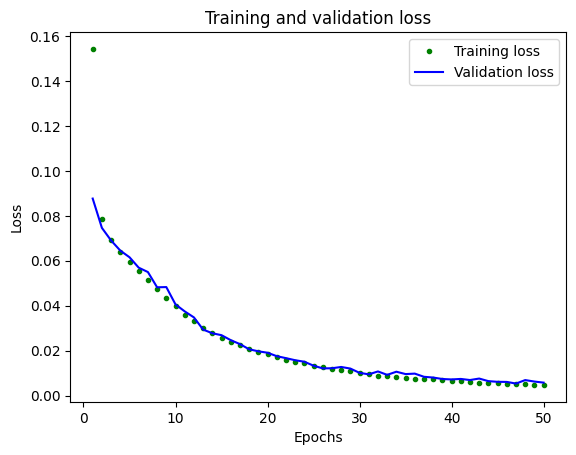

In [15]:
# Plot Mean Squared Error
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

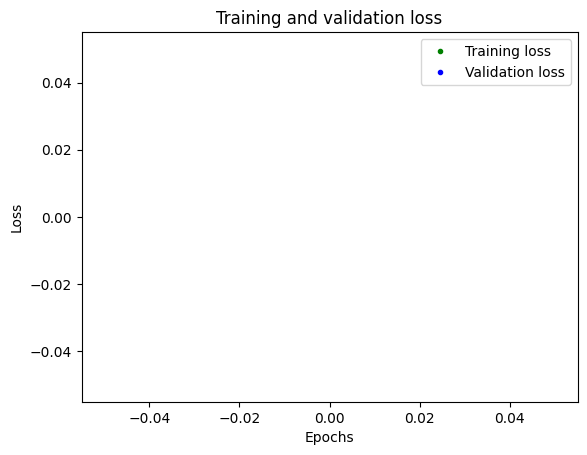

In [16]:
# Skip first 50 values and replot graph
SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2. Mean Absolute Error

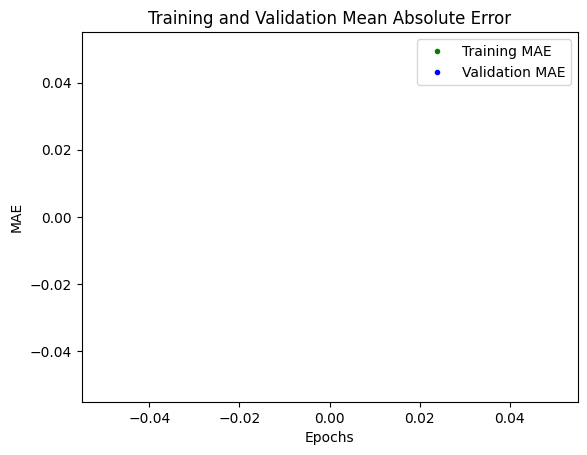

In [17]:
plt.clf()
# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [18]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(feature_test, target_test)

# Make predictions based on our test dataset
target_test_pred = model.predict(feature_test)

# print(feature_test)
# print(target_test)
#print(target_test_pred)

# print(feature_test)

87/87 [==============================] - 0s 1ms/step


# Model Evaluation

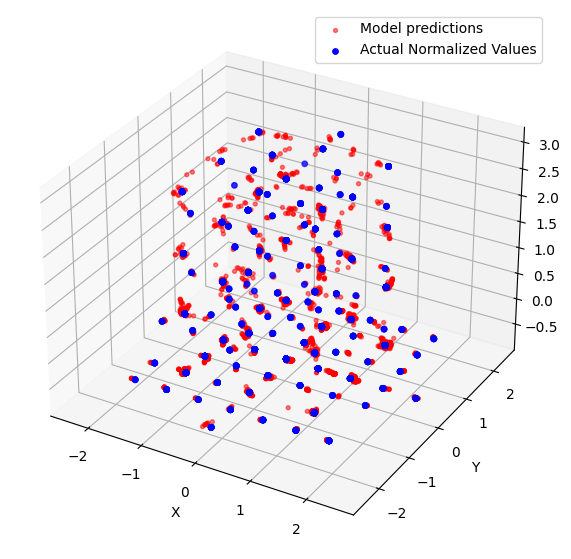

Average difference 63.21276889254914


In [19]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

df_sensors = feature_test
df_coordinates = target_test
coordinates2 = target_test_pred

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# scatter3D requires x, y, and z to be one-dimensional arrays
x = df_coordinates.iloc[:, 0]
y = df_coordinates.iloc[:, 1]
z = df_coordinates.iloc[:, 2]

x2 = coordinates2[:, 0]
y2 = coordinates2[:, 1]
z2 = coordinates2[:, 2]

ax.scatter3D(x2, y2, z2, c='red', s=8, alpha=0.5, label='Model predictions')  

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter3D(x, y, z, c='blue', s=15, label='Actual Normalized Values')

plt.legend()  # Show legend to differentiate between the two sets
plt.show()

diff_list = []
diff_tracker = 0
for i, (actual, predicted) in enumerate(zip(x, x2)):
    diff = actual/predicted*100
    diff_tracker += diff
    
avrg_diff = diff_tracker/i

print(f"Average difference {avrg_diff}")


In [20]:
# Check Mean Absolute Error
test_loss, test_mae = model.evaluate(feature_test, target_test, verbose=0)

print('Testing set Mean Abs Error: {:5.3f} mm'.format(test_mae))

# Convert to numpy arrays if they are pandas DataFrames
original_data = target_test.to_numpy()
predicted_data = target_test_pred

# Calculate Mean Squared Error
mse = np.mean((original_data - predicted_data) ** 2)

# Convert to Root Mean Squared Error
rmse = np.sqrt(mse)

# Estimate the range of the data
data_range = np.max(original_data) - np.min(original_data)

# Calculate accuracy percentage
accuracy = (1 - rmse / data_range) * 100
accuracy_percentage = np.clip(accuracy, 0, 100)  # Ensure the percentage is between 0 and 100

print("\n#-----------------------------------------------------")
print(f"# Model Accuracy: {accuracy_percentage:.2f}%")
print("#-----------------------------------------------------")


Testing set Mean Abs Error: 0.042 mm

#-----------------------------------------------------
# Model Accuracy: 98.53%
#-----------------------------------------------------


## Denormalize output 

In [21]:
# Check model output values
pred_df = pd.DataFrame(target_test_pred, columns = ['x','y','z'])
pred_df.head()

,x,y,z
0,1.234894,-1.167146,-0.564147
1,0.085707,-1.224568,-0.590418
2,0.023385,1.272182,-0.603744
3,0.050245,-1.214737,-0.572155
4,-1.187746,-1.190354,-0.570879


In [22]:
# Denormalize Values
def denorm(x):
  return (x * train_stats['std']) + train_stats['mean']

denormed_data = denorm(pred_df)
denormed_feature = denorm(feature)
denormed_target = denorm(target)

print(denormed_data.shape)
print(denormed_feature.shape)

print(f"Denormalized Mean Absolute Error {denorm(test_mae)}")

(2767, 11)
(13835, 11)
Denormalized Mean Absolute Error s1    434.729512
s2    355.751174
s3    405.930164
s4    354.084440
s5    334.381465
s6    382.891595
s7    317.878407
s8    382.244902
x       0.182295
y       0.200633
z       2.750391
dtype: float64


# Denormalized Evaluation

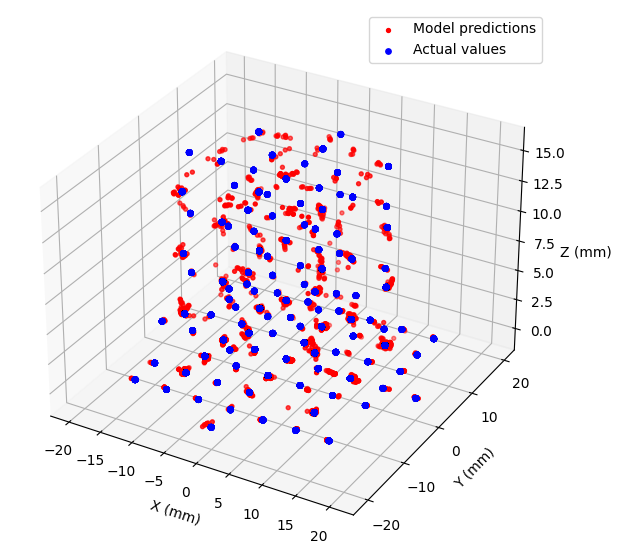

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming df_sensors is the 808x8 DataFrame, df_coordinates is the 808x3 DataFrame,
# and coordinates2 is the second 808x3 NumPy array
df_sensors = denormed_feature[['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8']]
df_coordinates = denormed_target[['x', 'y', 'z']]
coordinates2 = denormed_data[['x', 'y', 'z']]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# scatter3D requires x, y, and z to be one-dimensional arrays
x2 = coordinates2.iloc[:, 0]
y2 = coordinates2.iloc[:, 1]
z2 = coordinates2.iloc[:, 2]

ax.scatter3D(x2, y2, z2, c='red', s=8, label='Model predictions')  # Plot second set with different color

x = df_coordinates.iloc[:, 0]
y = df_coordinates.iloc[:, 1]
z = df_coordinates.iloc[:, 2]

ax.scatter3D(x, y, z, c='blue', s=15, label='Actual values')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('')
ax.text2D(1.02, 0.55, 'Z (mm)', transform=ax.transAxes, verticalalignment='center')

plt.legend()

plt.savefig("scatter_plot_4.svg", format='svg', bbox_inches='tight', pad_inches=0)
 
plt.show()



In [24]:
print(target_test_pred.shape)

print(target_test.shape)

print(denormed_target.shape)


(2767, 3)
(2767, 3)
(13835, 11)


### Model Accuracy

In [25]:
# Convert to numpy arrays if they are pandas DataFrames
original_data = target_test_og.to_numpy()
predicted_data = coordinates2

# Calculate Mean Squared Error
mse = np.mean((original_data - predicted_data) ** 2)

# Convert to Root Mean Squared Error
rmse = np.sqrt(mse)

# Estimate the range of the data
data_range = np.max(original_data) - np.min(original_data)

# Calculate accuracy percentage
accuracy = (1 - rmse / data_range) * 100
accuracy_percentage = np.clip(accuracy, 0, 100)  # Ensure the percentage is between 0 and 100

# accuracy_percentage

print("\n#-----------------------------------------------------")
print(f"# Denormalized Model Accuracy: {accuracy_percentage:.2f}%")
print("#-----------------------------------------------------")



#-----------------------------------------------------
# Denormalized Model Accuracy: 98.54%
#-----------------------------------------------------


# Generate aTensorflow Lite Model

In [26]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for _ in range(500):
    yield([feature_train.astype(np.float32)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

2024-02-22 21:09:56.336111: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-22 21:09:56.336162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-22 21:09:56.339765: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: models/model
2024-02-22 21:09:56.341436: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-02-22 21:09:56.341462: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: models/model
2024-02-22 21:09:56.347653: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-02-22 21:09:56.349045: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-02-22 21:09:56.418009: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: models/model
2024-02-22 21:09:56

24096

In [27]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(MODEL_NO_QUANT_TFLITE)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define your input here. I am using random for the simplicity
input_data = feature_test.to_numpy().astype(np.float32)

print(input_data)
print(input_data.shape[0])

start_time = time.time()

# Convert DataFrame to numpy array for correct indexing

# Assuming `feature_test_np` is a 2D numpy array with shape (808, 8)
for i in range(input_data.shape[0]):
    single_instance = np.expand_dims(input_data[i], axis=0)  # Reshape from (8,) to (1, 8)

    interpreter.set_tensor(input_details[0]['index'], single_instance)
    interpreter.invoke()

end_time = time.time()

# Time taken
print(f"Time taken for non-quantized prediction: {end_time - start_time} seconds")


[[ 1.2847426   1.0469317   0.17206264 ...  0.43838933 -1.1183898
  -2.0828176 ]
 [ 0.6254382   0.85479933  0.8453316  ... -0.5006057  -1.0913732
  -0.53974664]
 [-0.6931706  -1.1076959  -0.7472084  ...  0.6237173   0.77277577
   0.6515949 ]
 ...
 [ 0.15073903 -0.3254426  -0.060992   ... -0.95774806 -1.9288894
  -0.9595527 ]
 [-0.35033232 -0.3528901  -0.29404664 ...  0.7596245   1.2050421
   0.8331327 ]
 [ 0.79685736 -0.69598365 -2.8447     ...  1.5256468   1.1645172
  -0.53974664]]
2767
Time taken for non-quantized prediction: 0.04441428184509277 seconds


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [28]:

import time
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(MODEL_TFLITE)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define your input here. I am using random for the simplicity
# Assuming `input_data_normalized` is your normalized test data
input_data_quantized = (feature_test * 127).astype(np.int8)
input_data_quantized_np = input_data_quantized.to_numpy()
print(input_data_quantized)
print(input_data_quantized_np.shape[0])

start_time = time.time()
# Assuming `input_data_quantized_np` is a 2D numpy array with shape (808, 8)
for i in range(input_data_quantized_np.shape[0]):
    single_instance = np.expand_dims(input_data_quantized_np[i], axis=0)  # Reshape from (8,) to (1, 8)

    interpreter.set_tensor(input_details[0]['index'], single_instance)
    interpreter.invoke()


end_time = time.time()

# Time taken
print(f"Time taken for quantized prediction: {end_time - start_time} seconds")

        s1   s2   s3   s4   s5   s6   s7   s8
8301   -93 -124   21 -118 -124   55  114   -8
8302    79  108  107   34   21  -63  118  -68
8303   -88  116  -94  -42  -26   79   98   82
8304    76  115  113   27   24  -68  125  -65
8305    37  120 -118  -52 -123   61  -78   72
...    ...  ...  ...  ...  ...  ...  ...  ...
11063   64  -57   53  110 -124  -80 -105    0
11064  -56   57   21   20   80  -57   77 -107
11065   19  -41   -7  -79 -119 -121   12 -121
11066  -44  -44  -37   35   46   96 -103  105
11067  101  -88 -105 -102   10  -63 -109  -68

[2767 rows x 8 columns]
2767
Time taken for quantized prediction: 0.03234052658081055 seconds


In [29]:
size_tf_small = os.path.getsize(MODEL_NO_QUANT_TFLITE)
pd.DataFrame.from_records([["Tensorflow", f"{size_tf_small} bytes",""]], columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
Tensorflow,78356 bytes,


### Compare Quantized and Non Quantized Model

In [30]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [31]:
# Compare sizes
pd.DataFrame.from_records(
    [
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes "],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes"]],
     columns = ["Model", "Size"], index="Model")

,Size
Model,
TensorFlow Lite,78356 bytes
TensorFlow Lite Quantized,24096 bytes


### Generate TF Lite for Microcontroller Model

In [32]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/position_model/g' {MODEL_TFLITE_MICRO}

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)


In [33]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char position_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x84, 0x00, 0x00, 0x00, 0xdc, 0x00, 0x00, 0x00,
  0x38, 0x4f, 0x00, 0x00, 0x48, 0x4f, 0x00, 0x00, 0xb0, 0x5d, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xee, 0xae, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x38, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x98, 0xff, 0xff, 0xff,
  0x17, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x5f, 0x35, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x52, 0xb1, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00,
  0